<a href="https://colab.research.google.com/github/Offliners/Deep-Learning-note/blob/main/Chapter_2_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**匯入套件**

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np

**查看Keras、Tnesorflow和Python版本**

書中使用
```
Keras : 2.3.1
Tensorflow : 2.2.0
Python : 3.6.9
```

In [3]:
import keras
print("Keras : ", keras.__version__)
print("Tnesorflow : ", tf.__version__)

import sys
print("Python : ", sys.version)

tf.compat.v1.disable_eager_execution()  # 如果出現錯誤，可執行此行試看看

Keras :  2.4.3
Tnesorflow :  2.4.0
Python :  3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


**超參數設定**

In [16]:
batch_size = 100
original_dim = 28 * 28  # MNIST 影像高度 * 寬度
intermediate_dim = 256  # 中間層的維度
latent_dim = 2  # 潛在空間的維度
nb_epoch = 50

**建立取樣函式**

In [6]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)  # 建立一個平均值為0、標準差1、shape為(批次量，2)的隨機常態分布陣列

  return z_mean + K.exp(z_log_var / 2) * epsilon

**建立編碼器**

In [7]:
x = Input(shape=(original_dim,), name='input')  # 編碼器的輸入層
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)  # 中間層
z_mean = Dense(latent_dim, name='mean')(h)  # 潛在空間分布的平均值層
z_log_var = Dense(latent_dim, name='log-variance')(h)  # 潛在空間分布的對數變異數層
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  # 接收平均值與對數變異數的Lambda層，其輸出即為潛在空間z

encoder = Model(x, [z_mean, z_log_var, z], name='encoder')  # 用Model建立編碼器模型

**劃出encoder模型的結構圖**

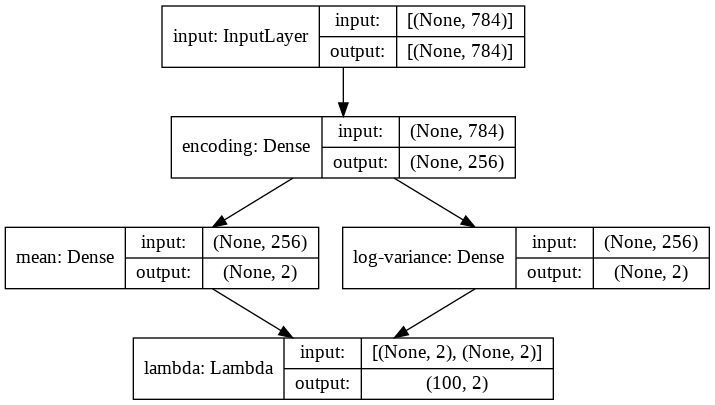

In [8]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

**製作解碼器**

In [9]:
input_decoder = Input(shape=(latent_dim,), name='decoder_input')  #解碼器的輸入層，可以輸入潛在空間的資料
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)  # 把輸入的潛在空間連到中間層
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)  # 還原到一開始的維度

decoder = Model(input_decoder, x_decoded, name='decoder')  #用Model建立解碼器

**劃出decoder模型的結構圖**

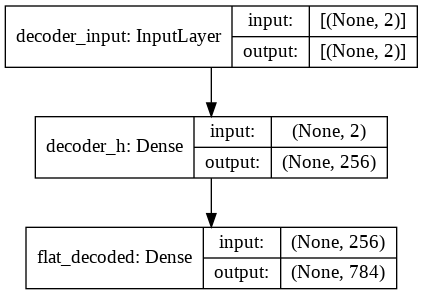

In [10]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

**結合兩模型**

In [11]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)  # 將最初輸入(x)到最後輸出結合為VAE模型

vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


**劃出vae模型的結構圖**

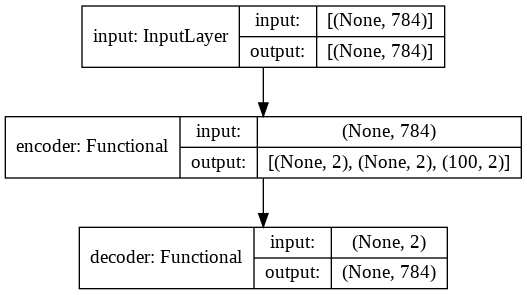

In [12]:
tf.keras.utils.plot_model(vae, show_shapes=True)

**定義損失函數**

In [13]:
def vae_loss(x, x_decoded_mean, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
  xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)  # 計算二元交叉熵 (binary cross-entropy)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # 計算相對熵 (KL divergence)

  return xent_loss + kl_loss  # 傳回以上2熵的和

vae.compile(optimizer='rmsprop', loss=vae_loss)  # 編譯模型

**取得訓練集與測試集**

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


In [17]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 130us/sample - loss: 162.0689 - val_loss: 161.6711
Epoch 2/50
60000/60000 [==============================] - 8s 129us/sample - loss: 160.9631 - val_loss: 160.7733
Epoch 3/50
60000/60000 [==============================] - 8s 130us/sample - loss: 159.9688 - val_loss: 159.8098
Epoch 4/50
60000/60000 [==============================] - 8s 130us/sample - loss: 159.0634 - val_loss: 158.9055
Epoch 5/50
60000/60000 [==============================] - 8s 133us/sample - loss: 158.2551 - val_loss: 158.2964
Epoch 6/50
60000/60000 [==============================] - 8s 132us/sample - loss: 157.5682 - val_loss: 157.6349
Epoch 7/50
60000/60000 [==============================] - 8s 129us/sample - loss: 156.9599 - val_loss: 157.6031
Epoch 8/50
60000/60000 [==============================] - 8s 133us/sample - loss: 156.4134 - val_loss: 156.7430
Epoch 9/50
60000/60000 [==============================

**將測試集資料映射到潛在空間後的二為分布圖**

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


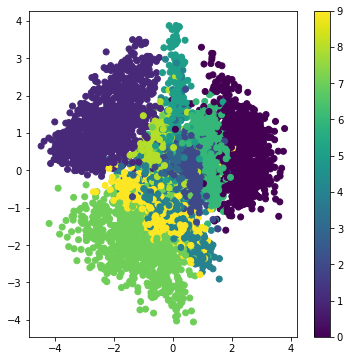

In [18]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

**將潛在空間的中央區域，以圓點為中心劃分成15 * 15塊區域**

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


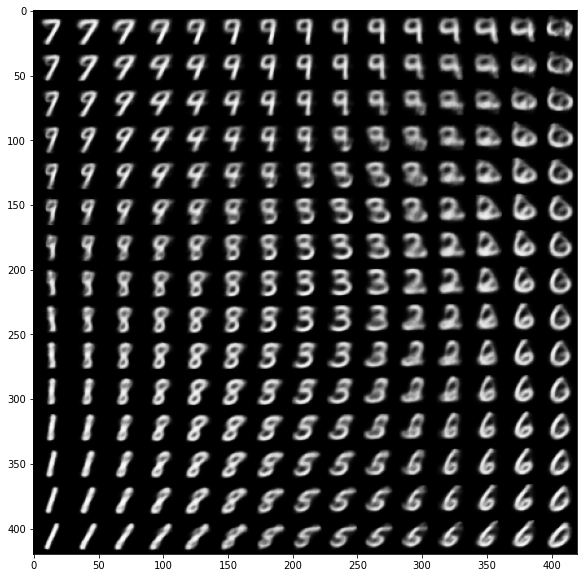

In [20]:
from scipy.stats import norm

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()